# Import The Required Libraries

In [23]:
import json
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# Load JSON File

In [2]:
JSON_PATH = "result.json"

In [4]:
json_path = Path(JSON_PATH)

raw_text = json_path.read_text(encoding="utf-8")

try:
    # Standard JSON (list or dict)
    data = json.loads(raw_text)
    if isinstance(data, dict) and "messages" in data:
        messages = data["messages"]
    else:
        messages = data
    print(f"Loaded {len(messages)} messages from JSON file.")
except json.JSONDecodeError:
    # Fallback: JSONL
    messages = []
    for i, line in enumerate(raw_text.splitlines(), start=1):
        line = line.strip()
        if not line:
            continue
        try:
            messages.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Skipping invalid JSON at line {i}")
    print(f"Loaded {len(messages)} messages from JSONL file.")

Loaded 4596 messages from JSON file.


# Flatten Telegram Text

In [6]:
rows = []

for msg in messages:
    # Combine Telegram text or text_entities into a single string
    if isinstance(msg.get("text"), list):
        full_text = "".join(
            t if isinstance(t, str) else t.get("text", "")
            for t in msg["text"]
        )
    elif isinstance(msg.get("text"), str):
        full_text = msg["text"]
    else:
        full_text = ""

    rows.append({
        "message_id": msg.get("id"),
        "date": msg.get("date"),
        "full_text": full_text
    })

records = pd.DataFrame(rows)

# Convert date to datetime (safe conversion)
records["date"] = pd.to_datetime(records["date"], errors="coerce")

records.head()

,message_id,date,full_text
0,1,2021-09-03 13:57:38,
1,12,2021-09-05 00:24:19,#خبر_مهم\n\nسلام به همه‌ی علموصی ها😍👊🏾\n\n✅این...
2,13,2021-09-05 00:24:25,
3,14,2021-09-05 00:34:39,🧑‍🏫 سید محمد شهرتاش\n🏫 #برق\n📒 بررسی ۱-بررسی۲-...
4,15,2021-09-05 00:35:51,🧑‍🏫 دکتر هاجر فلاحتی\n🏫 #مهندسی_کامپیوتر\n📒 مد...


# Extract Professor Name & Department

In [67]:
df = records[3:].copy()
df = df[~df["full_text"].str.contains("#رنج_نمرات|#معرفی_استاد", na=False)]
df["professor_name"] = df["full_text"].str.extract(
    r"(?:🧑‍🏫\s*)?([^\n\r]+)\n?\s*🏫"
)

df["department"] = df["full_text"].str.extract(
    r"#([^\s#]+)"
)

In [68]:
df[["professor_name", "department"]].head()

,professor_name,department
3,سید محمد شهرتاش,برق
4,دکتر هاجر فلاحتی,مهندسی_کامپیوتر
5,علم الهدی,مهندسی_مواد
6,حجت قاسمی,مکانیک
7,فریبرز قاسمی,مهندسی_کامپیوتر


# Extract Numeric Ratings (0–10)

In [69]:
ratings = {
    "coherence": "پیوستگی",
    "knowledge": "دانش عمومی",
    "teaching": "انتقال",
    "management": "مدیریت",
    "responsiveness": "پاسخگویی",
    "behavior": "آداب و رفتار"
}

for col, label in ratings.items():
    df[col] = (
        df["full_text"]
        .str.extract(fr"{label}[^\d]*(\d{{1,2}})")
        .astype(float)
        .clip(0, 10)
    )

df[list(ratings.keys())].head()

,coherence,knowledge,teaching,management,responsiveness,behavior
3,8.0,9.0,7.0,9.0,8.0,10.0
4,1.0,2.0,1.0,3.0,2.0,10.0
5,9.0,8.0,10.0,9.0,10.0,10.0
6,10.0,10.0,9.0,9.0,9.0,9.0
7,8.0,10.0,8.0,10.0,7.0,9.0


# EDA

### Basics

In [70]:
print("Total reviews:", len(df))
print("Unique professors:", df["professor_name"].nunique())
print("Departments:", df["department"].nunique())

Total reviews: 4319
Unique professors: 1296
Departments: 18


### Missing Values

In [71]:
df.isna().sum().sort_values(ascending=False)

professor_name    43
coherence         43
knowledge         43
teaching          43
management        43
responsiveness    43
behavior          43
department        42
message_id         0
date               0
full_text          0
dtype: int64

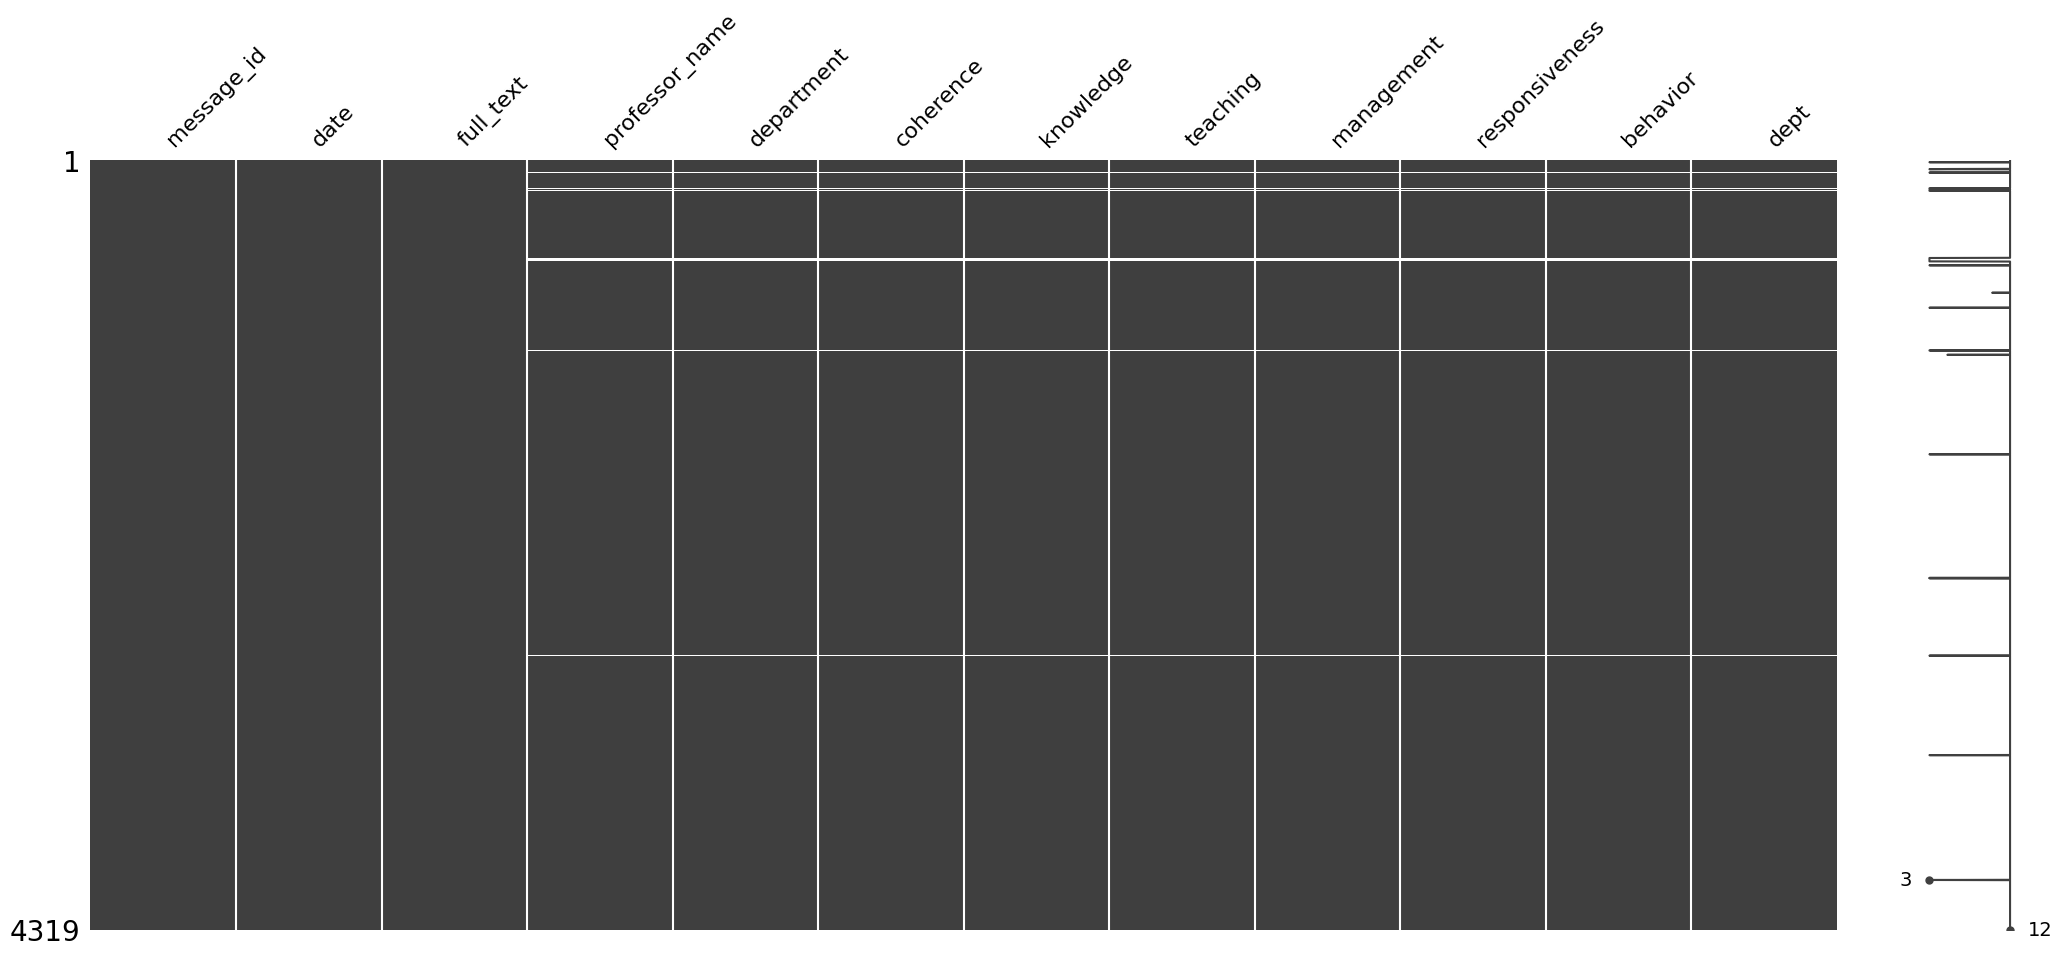

In [105]:
msno.matrix(df)
plt.show()

### Rating Distributions

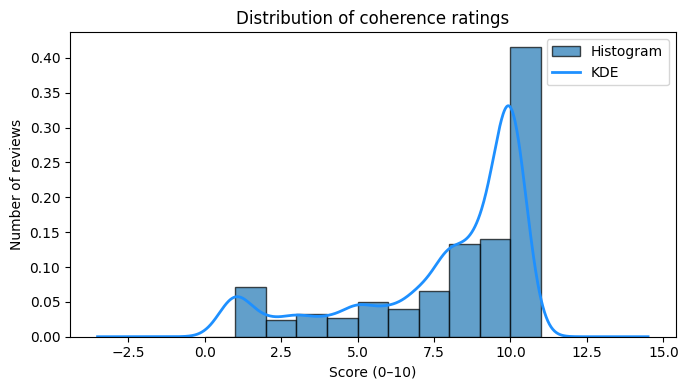

  Count   : 4276
  Mean    : 7.76
  Median  : 9.00
  Std dev : 2.84


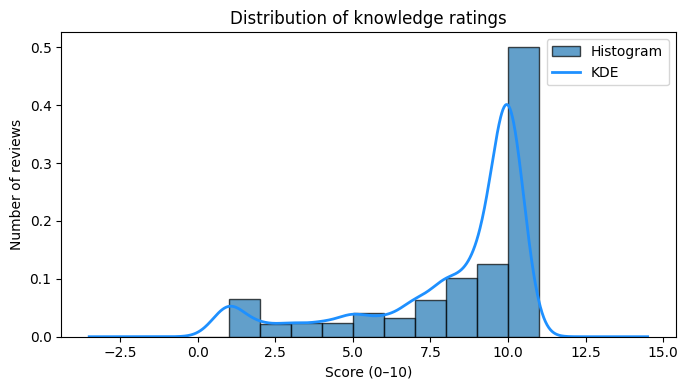

  Count   : 4276
  Mean    : 8.07
  Median  : 10.00
  Std dev : 2.76


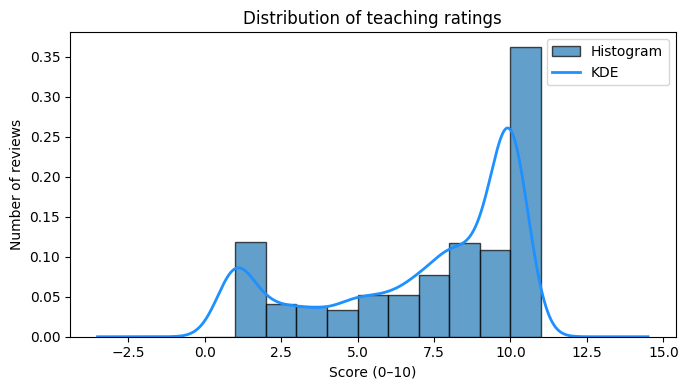

  Count   : 4276
  Mean    : 7.10
  Median  : 8.00
  Std dev : 3.20


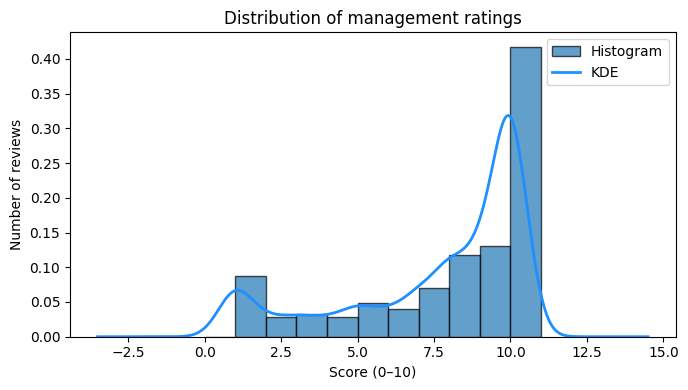

  Count   : 4276
  Mean    : 7.61
  Median  : 9.00
  Std dev : 2.98


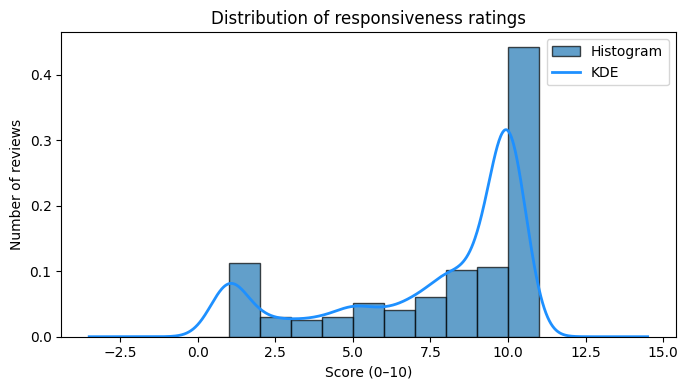

  Count   : 4276
  Mean    : 7.48
  Median  : 9.00
  Std dev : 3.17


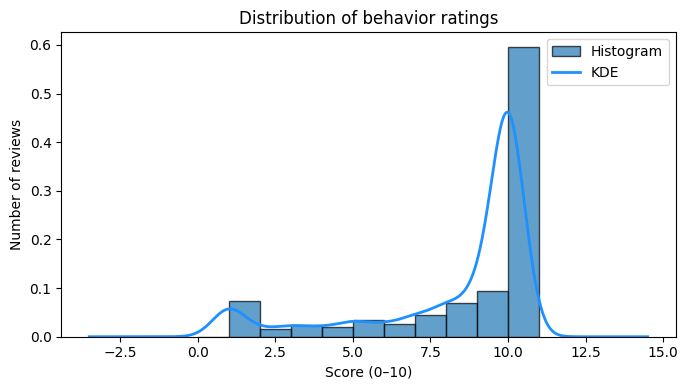

  Count   : 4276
  Mean    : 8.28
  Median  : 10.00
  Std dev : 2.82


In [73]:
rating_cols = list(ratings.keys())

for col in rating_cols:
    data = df[col].dropna()
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    count_val = data.count()

    # Plot
    plt.figure(figsize=(7, 4))
    plt.hist(data, bins=range(0, 12),density=True, edgecolor="black", alpha=0.7, label="Histogram")
    data.plot(kind="kde", linewidth=2, label="KDE", color='dodgerblue')

    plt.title(f"Distribution of {col} ratings")
    plt.xlabel("Score (0–10)")
    plt.ylabel("Number of reviews")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Numeric summary (for report tables)
    print(f"  Count   : {count_val}")
    print(f"  Mean    : {mean_val:.2f}")
    print(f"  Median  : {median_val:.2f}")
    print(f"  Std dev : {std_val:.2f}")

In [74]:
temp_dict = {
    'برق': 'EE',
    'مهندسی_کامپیوتر': 'CE',
    'مهندسی_مواد': 'MSE',
    'مکانیک': 'ME',
    'فیزیک': 'PHY',
    'معرفی_استاد': 'PROF-INTRO ',
    'ریاضی': 'MATH',
    'مهندسی_صنایع': 'IE',
    'مهندسی_شیمی': 'CHE',
    'معارف': 'ISL-ST',
    'مهندسی_عمران': 'CIVE',
    'تربیت_بدنی': 'PE',
    'مهندسی_راه_آهن': 'RE',
    'معماری_و_شهرسازی': 'ARCH',
    'شیمی': 'CHEM',
    'طراحی_صنعتی': 'ID',
    'مهندسی_خودرو': 'AE',
    'مهندسی_پیشرفت': 'PE',
    'فناوری_های_نوین': 'MT',
}

df['dept'] = df['department'].map(temp_dict)

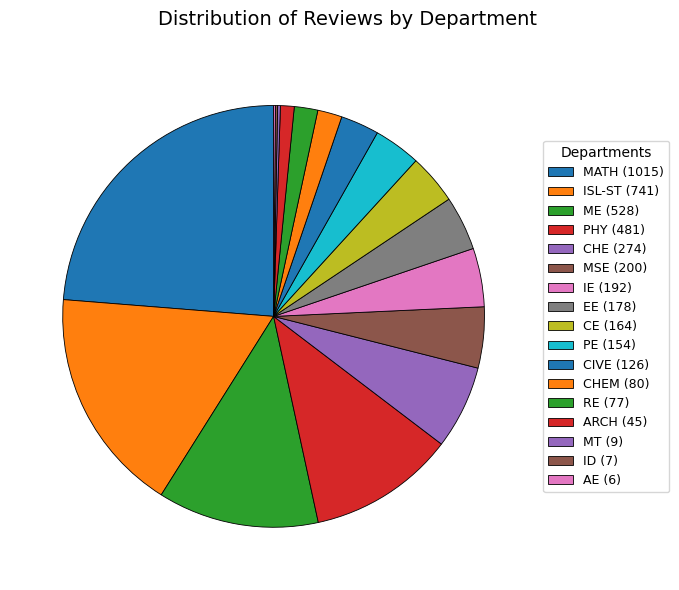

In [93]:
plt.figure(figsize=(10, 6))

dept_counts = df["dept"].value_counts()

wedges, texts = plt.pie(dept_counts.values, startangle=90,
                        textprops={'fontsize': 9}, 
                        wedgeprops={'edgecolor': 'black', 'linewidth': 0.6})

# Hide the percentage labels
plt.title('Distribution of Reviews by Department', loc='right', fontsize=14, pad=20)
plt.ylabel('')

# Legend with department names and counts
legend_labels = [f'{dept} ({count})' for dept, count in zip(dept_counts.index, dept_counts.values)]
plt.legend(wedges, legend_labels, title='Departments', loc='center left',
           bbox_to_anchor=(1, 0, 0.5, 1),
           fontsize=9,
           title_fontsize=10)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

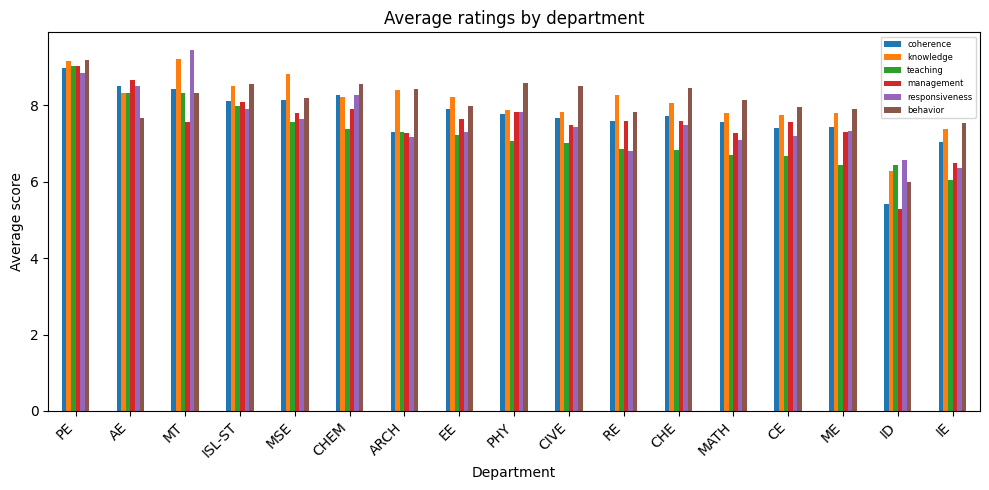

In [ ]:
dept_avg = df.groupby("dept")[rating_cols].mean().sort_values("teaching", ascending=False)

ax = dept_avg.plot(kind="bar", figsize=(10, 5))
plt.title("Average ratings by department")
plt.xlabel("Department")
plt.ylabel("Average score")
plt.xticks(rotation=45, ha="right")

plt.legend(fontsize=6, title_fontsize=7)
plt.tight_layout()
plt.show()